# L1 - ImageNet pretrained ResNets with STONEFLY9 dataset<br><br>Single image predictions

In this notebook a ImageNet pretrained ResNet is trained on the [STONEFLY9 dataset](http://web.engr.oregonstate.edu/~tgd/bugid/stonefly9/).<br>

The base notebook can be found here: https://github.com/MicPie/fastai_course_v3/blob/master/L1-stonefly.ipynb

## Notebook setup

In [1]:
# notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import fastai library
from fastai import *
from fastai.vision import *

## Data setup

In [3]:
# set path to data directory
path = Path('/home/paperspace/fastai/data/stonefly')

In [4]:
size = 224 # image size used for training (Note: is only applied when ds_tfms are set)
bs = 64 # batchsize for training

### Dataframe setup

In [5]:
# read in text file with a list of all the files
df = pd.read_csv(path/'files.txt', sep=' ', header=None, names=['imgurl'])

In [6]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/', 6)[-1] # split only 6 times

In [7]:
# define string manipulation lambda function to get path after the defined path variable
f = lambda x: x.split('/', 6)[-1]
df['imgurl'] = df['imgurl'].apply(f)

In [8]:
# test of string manipulation to get the data class
#('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125.jpg').split('/')[-3]

In [9]:
# define string manipulation lambda function to get data class
f = lambda x: x.split('/')[-3]
df['class'] = df['imgurl'].apply(f)

In [10]:
# verify dataframe
df.head()

,imgurl,class
0,JPEG_lowRes/cal/set0/Cal_10-specimen-i001-s125...,cal
1,JPEG_lowRes/cal/set0/Cal_10-specimen-i002-s125...,cal
2,JPEG_lowRes/cal/set0/Cal_10-specimen-i003-s125...,cal
3,JPEG_lowRes/cal/set0/Cal_10-specimen-i004-s125...,cal
4,JPEG_lowRes/cal/set0/Cal_10-specimen-i005-s125...,cal


In [11]:
df.tail()

,imgurl,class
3840,JPEG_lowRes/zap/set2/Zap_99-specimen-i001-s125...,zap
3841,JPEG_lowRes/zap/set2/Zap_99-specimen-i002-s125...,zap
3842,JPEG_lowRes/zap/set2/Zap_99-specimen-i003-s125...,zap
3843,JPEG_lowRes/zap/set2/Zap_99-specimen-i004-s125...,zap
3844,JPEG_lowRes/zap/set2/Zap_99-specimen-i005-s125...,zap


### ImageDataBunch setup

In [12]:
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=size, bs=bs)

In [13]:
# normalize data with the imagent_stats
data.normalize(imagenet_stats)

In [14]:
# verify ImageDataBunch setup
data.path

PosixPath('/home/paperspace/fastai/data/stonefly')

In [15]:
# check if dataset classes equal datatset class count
len(data.train_ds.classes), data.train_ds.c

(9, 9)

### Data exploration

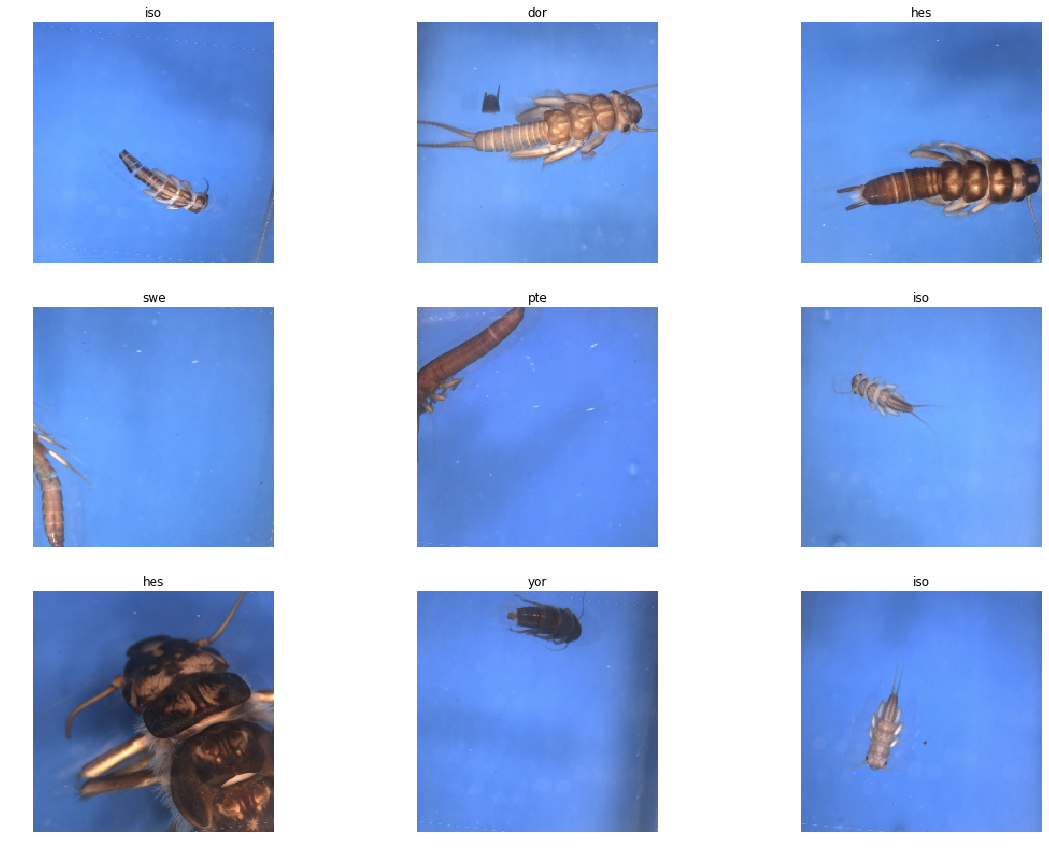

In [16]:
data.show_batch(rows=3, figsize=(17,12))

## Single image prediction with ResNet34 (work in progress)

In [16]:
# setup classes list
classes = ['cal', 'dor', 'hes', 'iso', 'mos', 'pte', 'swe', 'yor', 'zap']#; classes

### Setup full learner model

In [17]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:41 2018
[0] Quadro P4000     | 34'C,   0 % |   563 /  8119 MB | paperspace(553M)


In [18]:
learn_full = Learner.create_cnn(data, models.resnet34, metrics=accuracy) #, callback_fns=ActivationStats)

In [19]:
learn_full.load('stonefly_resnet34_stage_2')

In [20]:
# show model
#learn.model

In [21]:
learn_full.model.eval();

In [22]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:43 2018
[0] Quadro P4000     | 34'C,   7 % |   685 /  8119 MB | paperspace(675M)


### Setup model with empty ds

In [23]:
# From https://forums.fast.ai/t/how-to-get-an-empty-convlearner-for-single-image-prediction/28245/16

In [24]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:43 2018
[0] Quadro P4000     | 34'C,   0 % |   685 /  8119 MB | paperspace(675M)


In [25]:
# creat empty dataset: ImageClassificationDataset(fns, labels, classes)
# fns & labels are just a dummy vaue, classes list is handed over for the prediction
ds_empty = ImageClassificationDataset([classes[0]], [classes[0]], classes)

In [26]:
data_empty = ImageDataBunch.create(ds_empty, ds_empty, str(path/'tmp'), ds_tfms=get_transforms(), size=size)

In [27]:
learn_empty = Learner.create_cnn(data_empty, models.resnet34, metrics=accuracy)

In [28]:
learn_empty.model.eval();

In [29]:
learn_empty.load(path/'models/stonefly_resnet34_stage_2')

In [30]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:44 2018
[0] Quadro P4000     | 34'C,   2 % |   787 /  8119 MB | paperspace(777M)


### Setup model without learner

In [31]:
# From https://forums.fast.ai/t/using-our-trained-model-against-a-specific-image/28262

In [32]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:46 2018
[0] Quadro P4000     | 35'C,   0 % |   787 /  8119 MB | paperspace(777M)


In [33]:
# show original model structure
#models.resnet34()

In [34]:
# create backbone NN from ResNet34 model and cut off the last two layers
backbone = create_body(models.resnet34(), -2)#, backbone

In [35]:
# show backbone
#backbone

In [36]:
# create custom head for backbone with needed number of output features
head = create_head(num_features(backbone)*2, len(classes))#, head

In [37]:
# show head structure
#head

In [38]:
# stick backbone and head together
m_wo = nn.Sequential(backbone, head)

In [39]:
# load save weights from training the ResNet34 (see above)
m_wo.load_state_dict(torch.load(path/'models/stonefly_resnet34_stage_2.pth'))

In [40]:
# put model into evaluation mode and suppress output
m_wo.eval();

In [41]:
!gpustat

psbtmxtmo  Sun Oct 28 12:26:49 2018
[0] Quadro P4000     | 35'C,   0 % |   787 /  8119 MB | paperspace(777M)


### Load image for prediction

In [73]:
# set image number for prediction
img_num = 3036

In [74]:
img_path = path/df.iloc[img_num,0]; img_path

PosixPath('/home/paperspace/fastai/data/stonefly/JPEG_lowRes/yor/set1/Yor_103-specimen-i004-s125.jpg')

In [75]:
# show image with matplotlib
#plt.imshow(plt.imread(img_path))

In [76]:
# open image
img = open_image(img_path)#; img

#### Image transformation, visualization, and shape check (optional)

In [77]:
# setup transformations
train_tfms, valid_tfms = get_transforms()

In [78]:
# apply transformations
img_tfm = apply_tfms(valid_tfms.append(normalize_funcs(*imagenet_stats)), img, size=size)

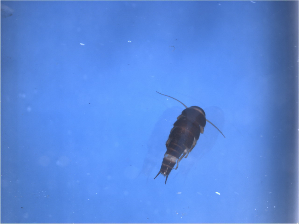

In [79]:
# show transformed image
img_tfm

In [80]:
# check shapes
img_tfm.data.shape#, img_tfm.data

torch.Size([3, 224, 299])

In [81]:
# unsequeeze to add dimension for batches used in training
img_tfm.data.unsqueeze(0).shape #, img_tfm.data.unsqueeze(0)

torch.Size([1, 3, 224, 299])

### Predict with full learner model

In [82]:
log_preds_full = Image.predict(img, learn_full); log_preds_full

tensor([-5.9760, -8.5111, -0.4286, -1.6558, -4.0587, -3.0411, -2.9272, 19.6251,
        -0.6711])

In [83]:
preds_full = torch.argmax(log_preds_full); preds_full

tensor(7)

In [98]:
classes[torch.argmax(log_preds_full)]

'yor'

In [86]:
# show original label
df.iloc[img_num,1]

'yor'

### Predict with model with empty ds

In [87]:
log_preds_empty = Image.predict(img, learn_empty); log_preds_empty

tensor([-8.2881, -5.6897,  4.8526, 10.3844, -5.5605, -8.8430,  1.8328, -0.4876,
         4.5716])

In [88]:
preds_empty = torch.argmax(log_preds_empty); preds_empty

tensor(3)

In [89]:
classes[preds_empty]

'iso'

In [90]:
# show original label
df.iloc[img_num,1]

'yor'

### Predict with model without learner

In [91]:
log_preds_wo = m_wo(img_tfm.data.unsqueeze(0)); log_preds_wo

tensor([[-8.2196, -6.0990,  5.7681, 11.8358, -5.6677, -9.4471,  0.1673, -0.4162,
          4.7292]], grad_fn=<ThAddmmBackward>)

In [92]:
# argmax of log_preds
torch.argmax(log_preds_wo)

tensor(3)

In [96]:
# show predicted label
classes[torch.argmax(log_preds_wo)]

'iso'

In [97]:
# show original label
df.iloc[img_num,1]

'yor'